In [1]:
import numpy as np   
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import librosa
import tensorflow as tf 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
def load_and_preprocess_data(audio_path,label):
    audio,sr = librosa.load(audio_path,sr=16000,mono=True)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return mfccs.T, label

def prepare_dataset(real_paths, fake_paths):
    X, y = [], []
    for path in real_paths:
        features, label = load_and_preprocess_data(path, 0)  # 0 for real
        X.append(features)
        y.append(label)

    for path in fake_paths:
        features, label = load_and_preprocess_data(path, 1)
        X.append(features)
        y.append(label)

    return X,np.array(y)

In [3]:
def augment_data(X,y):
    augmented_X , augmented_y = [], []
    
    for features,label in zip(X,y):
        augmented_X.append(features)
        augmented_y.append(label)
        
        audio_signal = librosa.effects.time_stretch(features.T[0], rate=0.8)  
        augmented_X.append(librosa.feature.mfcc(y=audio_signal, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)

        audio_signal_shifted = librosa.effects.pitch_shift(features.T[0], sr=22050,n_steps=2)
        augmented_X.append(librosa.feature.mfcc(y=audio_signal_shifted, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)

    return augmented_X, np.array(augmented_y)


In [4]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [5]:
def train_and_evaluate(model,X_train,y_train,X_test,y_test,epochs=50,batch_size=16):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,verbose=2)
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'\nTest accuracy: {test_acc}')


    return history

In [6]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [8]:
import os

In [9]:
base_path = '../deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO'
print("Checking REAL folder:", os.path.exists(os.path.join(base_path, "REAL")))
print(os.getcwd())

Checking REAL folder: True
d:\deepfake_voice\notebook


In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Masking

(192, 5000, 13)
Epoch 1/50
8/8 - 50s - 6s/step - accuracy: 0.8607 - loss: 0.4707 - val_accuracy: 0.8710 - val_loss: 0.3949
Epoch 2/50
8/8 - 41s - 5s/step - accuracy: 0.8852 - loss: 0.3821 - val_accuracy: 0.8710 - val_loss: 0.3955
Epoch 3/50
8/8 - 44s - 5s/step - accuracy: 0.8852 - loss: 0.3636 - val_accuracy: 0.8710 - val_loss: 0.4008
Epoch 4/50
8/8 - 151s - 19s/step - accuracy: 0.8852 - loss: 0.3517 - val_accuracy: 0.8710 - val_loss: 0.3993
Epoch 5/50
8/8 - 222s - 28s/step - accuracy: 0.8852 - loss: 0.3380 - val_accuracy: 0.8710 - val_loss: 0.4039
Epoch 6/50
8/8 - 212s - 26s/step - accuracy: 0.8852 - loss: 0.3272 - val_accuracy: 0.8710 - val_loss: 0.3940
Epoch 7/50
8/8 - 213s - 27s/step - accuracy: 0.8852 - loss: 0.3076 - val_accuracy: 0.8710 - val_loss: 0.3906
Epoch 8/50
8/8 - 48s - 6s/step - accuracy: 0.8852 - loss: 0.3257 - val_accuracy: 0.8710 - val_loss: 0.3863
Epoch 9/50
8/8 - 113s - 14s/step - accuracy: 0.8852 - loss: 0.2920 - val_accuracy: 0.8710 - val_loss: 0.3878
Epoch 10/50

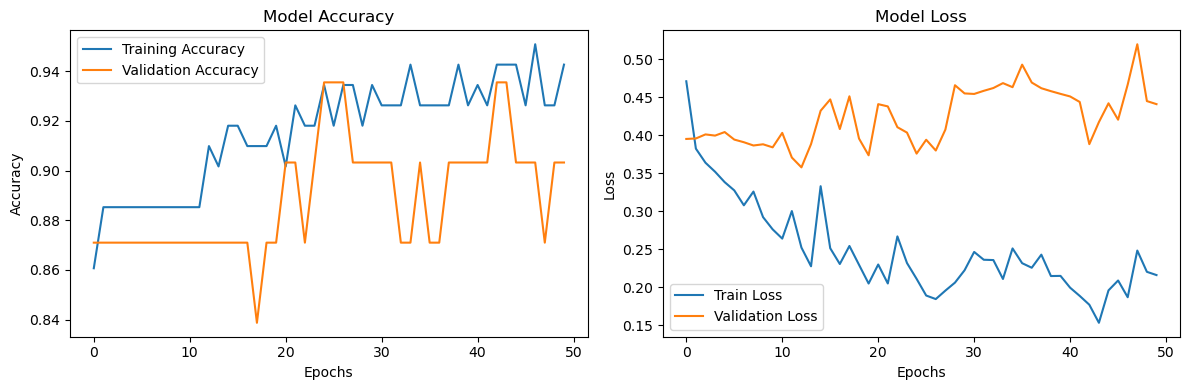

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


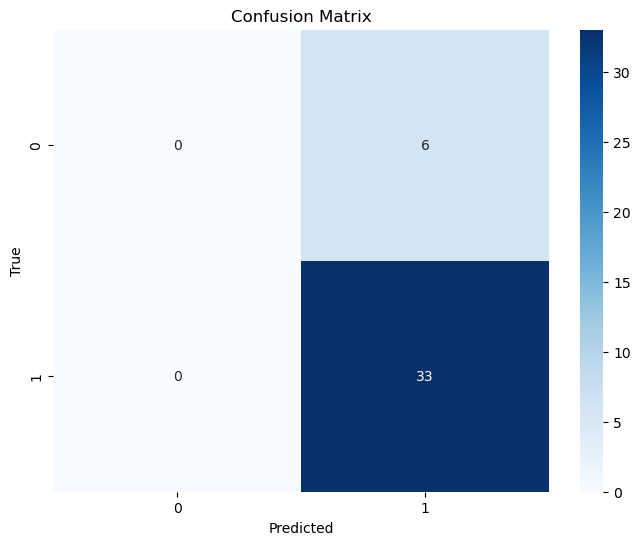

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.85      1.00      0.92        33

    accuracy                           0.85        39
   macro avg       0.42      0.50      0.46        39
weighted avg       0.72      0.85      0.78        39



d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
real_paths = [os.path.join(base_path, "REAL", f) for f in os.listdir(os.path.join(base_path, "REAL")) if f.endswith('.wav')]
fake_paths = [os.path.join(base_path, "FAKE", f) for f in os.listdir(os.path.join(base_path, "FAKE")) if f.endswith('.wav')]

X,y = prepare_dataset(real_paths, fake_paths)
X_augmented, y_augmented = augment_data(X, y)

max_length = min(max(len(seq) for seq in X_augmented),5000)
X_padded = pad_sequences(X_augmented, maxlen=max_length, dtype='float32',padding='post', truncating='post')
print(X_padded.shape)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_augmented, test_size=0.2, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = train_and_evaluate(model, X_train, y_train, X_test, y_test)

plot_training_history(history)
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


In [19]:
!pip install librosa


In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2055735607253740902
xla_global_id: -1
]


In [13]:
import librosa
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def preprocess_audio(audio_path, max_length):
    audio, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs = mfccs.T
    padded_mfccs = pad_sequences([mfccs], maxlen=max_length, dtype='float32', padding='post', truncating='post')
    return padded_mfccs

In [ ]:
test_audio_paths = ['../deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-taylor.wav']

for audio_path in test_audio_paths:
    padded_sample = preprocess_audio(audio_path, max_length=X_train.shape[1])
    prediction = model.predict(padded_sample)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    if predicted_class == 1:
        print(f"The audio {audio_path} is predicted as FAKE.")
    else:
        print(f"The audio {audio_path} is predicted as REAL.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
The audio ../deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-taylor.wav is predicted as FAKE.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
The audio ../deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav is predicted as REAL.


In [15]:
model.save('deepfake_voice_model_new.h5')